## <a id='toc1_'></a>[Football Dataset Cleaning and Analysis](#toc0_)

In this notebook, we will apply feature engineering teqniques to a football-related dataset to analyze the likelihood of scoring a goal through a shot. 

## <a id='toc2_'></a>[Authors](#toc0_)
* **Alireza Arbabi**
* **Hadi Babalou**
* **Ali Padyav**
* **Kasra Hajiheidari**

**Table of contents**<a id='toc0_'></a>    
- [Football Dataset Cleaning and Analysis](#toc1_)    
- [Authors](#toc2_)    
- [Setting Up the Environment](#toc3_)    
- [Data Preparation](#toc4_)    
  - [Dataset Description](#toc4_1_)    
  - [Loading the Dataset](#toc4_2_)    
  - [Preprocessing](#toc4_3_)    
    - [Missing Values](#toc4_3_1_)    
    - [Duplicates](#toc4_3_2_)    
    - [Type Conversion](#toc4_3_3_)    
    - [Feature Engineering](#toc4_3_4_)    
      - [Goal (Boolean)](#toc4_3_4_1_)    
      - [Seconds Passed](#toc4_3_4_2_)    
      - [Shot Distance](#toc4_3_4_3_)    
      - [Shot Angle](#toc4_3_4_4_)    
      - [Outside Box](#toc4_3_4_5_)    
      - [Reorder Columns](#toc4_3_4_6_)    
- [Feature Distribution](#toc5_)    
- [Feature Importance](#toc6_)    
  - [Mutual Information](#toc6_1_)    
  - [Correlation](#toc6_2_)    
- [Evaluation](#toc7_)    
  - [Train-Test Split](#toc7_1_)    
  - [Training a Model](#toc7_2_)    
  - [Evaluation](#toc7_3_)    
    - [Raw data](#toc7_3_1_)    
  - [Modified data](#toc7_4_)    
- [Heat Map](#toc8_)    
- [Questions](#toc9_)    
  - [Question 1](#toc9_1_)    
  - [Question 2](#toc9_2_)    
  - [Question 3](#toc9_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc3_'></a>[Setting Up the Environment](#toc0_)

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install tqdm
# !pip install scipy
# !pip install scikit-learn
# !pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
TEST_RATIO = 0.2
RANDOM_STATE = 17
N_ESTIMATORS = 20
MAX_DEPTH = 6

GOAL_LENGTH = 7.32
GOAL_HEIGHT = 2.44
MIN_FIELD_LENGTH = 90
MAX_FIELD_LENGTH = 120
MIN_FIELD_WIDTH = 45
MAX_FIELD_WIDTH = 90
CORNER_RADIUS = 1
CENTER_CIRCLE_RADIUS = 9.15
PENALTY_MARK_DISTANCE = 11
PENALTY_AREA_LENGTH = 16.5
PENALTY_AREA_WIDTH = 40.32
GOAL_AREA_LENGTH = 5.5
GOAL_AREA_WIDTH = 18.32
PENALTY_MARK_RADIUS = 0.1

## <a id='toc4_'></a>[Data Preparation](#toc0_)

### <a id='toc4_1_'></a>[Dataset Description](#toc0_)

The dataset contains information about the shots taken during football matches, such as the distance from the goal, location (corner, penalty, etc.), the outcome of the shots (saved by the keeper, blocked by defenders, missed, etc), and more.

Here is the list of columns in the dataset:

- `matchId`: The unique identifier of the match.
- `playerId`: The unique identifier of the player.
- `playType`: The type of play (e.g., corner, free kick, penalty, open play, etc.).
- `bodyPart`: The body part used to take the shot (e.g., right foot, left foot, head).
- `x`, `y`: The coordinates of the shot.
- `interveningOpponents`: The number of opponents between the shooter and the goal.
- `interveningTeammates`: The number of teammates between the shooter and the goal.
- `interferenceOnShooter`: Level of interference on the shooter (low, medium, high).  
low means there are no opponents in 1 meter of the shooter, medium means there is an opponent in 1 meter of the shooter, and high means there are more than one opponent in 1 meter of the shooter.
- `minute`: The minute of the match when the shot was taken.
- `second`: The second of the minute when the shot was taken.
- `outcome`: The outcome of the shot (e.g., goal, saved by keeper, blocked by defenders, missed chanced, etc.).

The following columns are added to the dataset:

- `shotDistance`: The distance of the shot from the goal.
- `shotAngle`: The angle shot makes with the goal.
- `outsideBox`: A binary column indicating whether the shot was taken from outside the penalty box.
- `secondsPassed`: The number of seconds passed since the beginning of the match.
- `goal`: A binary column indicating whether the shot resulted in a goal or not.

### <a id='toc4_2_'></a>[Loading the Dataset](#toc0_)

In [4]:
DATASET_PATH = 'football.csv'
df = pd.read_csv(DATASET_PATH)
df.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8925 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8925 non-null   object 
 1   playerId               8925 non-null   object 
 2   playType               8925 non-null   object 
 3   bodyPart               8925 non-null   object 
 4   x                      8925 non-null   float64
 5   y                      8925 non-null   float64
 6   interveningOpponents   8925 non-null   int64  
 7   interveningTeammates   8925 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8925 non-null   int64  
 10  second                 8925 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 836.8+ KB


In [6]:
df.describe()

,x,y,interveningOpponents,interveningTeammates,minute,second
count,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000
mean,14.564631,0.364408,2.531989,0.336471,48.541401,29.243810
std,7.841865,8.999063,1.386693,0.680175,26.397998,17.306565
min,0.000000,-33.920000,0.000000,0.000000,0.000000,0.000000
25%,8.480000,-5.740000,2.000000,0.000000,26.000000,14.000000
50%,12.470000,0.500000,2.000000,0.000000,49.000000,29.000000
75%,20.950000,6.730000,3.000000,0.000000,71.000000,44.000000
max,70.820000,33.920000,11.000000,7.000000,98.000000,59.000000


### <a id='toc4_3_'></a>[Preprocessing](#toc0_)

#### <a id='toc4_3_1_'></a>[Missing Values](#toc0_)

In [7]:
print(df.isnull().sum())

matchId                   0
playerId                  0
playType                  0
bodyPart                  0
x                         0
y                         0
interveningOpponents      0
interveningTeammates      0
interferenceOnShooter    34
minute                    0
second                    0
outcome                  34
dtype: int64


As we can see, there are some missing values in `interferenceOnShooter` and `outcome` columns. Because the `outcome` column is our target variable, we will first drop the rows with missing values in this column.

In [8]:
df.dropna(subset=['outcome'], inplace=True)

In [9]:
print(df.isnull().sum())

matchId                  0
playerId                 0
playType                 0
bodyPart                 0
x                        0
y                        0
interveningOpponents     0
interveningTeammates     0
interferenceOnShooter    0
minute                   0
second                   0
outcome                  0
dtype: int64


We can see that the rows with missing value for `interferenceOnShooter` are also missing the value for `outcome`. Therefore, after dropping the rows with missing values in the `outcome` column, we will no longer have any missing values in the dataset.

#### <a id='toc4_3_2_'></a>[Duplicates](#toc0_)

There is no duplicate data in the dataset.

In [10]:
print(df.duplicated().sum())

0


#### <a id='toc4_3_3_'></a>[Type Conversion](#toc0_)

In [11]:
print(df.dtypes)

matchId                   object
playerId                  object
playType                  object
bodyPart                  object
x                        float64
y                        float64
interveningOpponents       int64
interveningTeammates       int64
interferenceOnShooter     object
minute                     int64
second                     int64
outcome                   object
dtype: object


Now we will convert categorical columns to the appropriate data type.

In [12]:
df['playType'] = df['playType'].astype('category')
df['playType'].value_counts()

open play    8344
free kick     417
penalty       126
olimpico        4
Name: playType, dtype: int64

In [13]:
df['bodyPart'] = df['bodyPart'].astype('category')
df['bodyPart'].value_counts()

right foot    4440
left foot     2892
head          1508
other           51
Name: bodyPart, dtype: int64

We can convert the `interferenceOnShooter` column to an ordered categorical type. This will help us later when we perform the analysis.

In [14]:
df['interferenceOnShooter'] = df['interferenceOnShooter'].astype('category')
df['interferenceOnShooter'].cat.reorder_categories(['low', 'medium', 'high'], ordered=True, inplace=True)
df['interferenceOnShooter'].value_counts()

medium    4186
low       3315
high      1390
Name: interferenceOnShooter, dtype: int64

In [15]:
df['outcome'] = df['outcome'].astype('category')
df['outcome'].value_counts()

missed chance      3470
saved by keeper    2395
blocked shot       1771
goal               1081
hit the post        174
Name: outcome, dtype: int64

In [16]:
df.dtypes

matchId                    object
playerId                   object
playType                 category
bodyPart                 category
x                         float64
y                         float64
interveningOpponents        int64
interveningTeammates        int64
interferenceOnShooter    category
minute                      int64
second                      int64
outcome                  category
dtype: object

#### <a id='toc4_3_4_'></a>[Feature Engineering](#toc0_)

##### <a id='toc4_3_4_1_'></a>[Goal (Boolean)](#toc0_)

We can add a new column called `goal` which is a boolean column indicating whether the shot resulted in a goal or not. This could be a target variable for a classification model.

In [17]:
df['goal'] = df['outcome'].apply(lambda x: True if x == 'goal' else False)
df.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,goal
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal,True
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper,False
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper,False
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance,False
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal,True


##### <a id='toc4_3_4_2_'></a>[Seconds Passed](#toc0_)

We can convert the `minute` and `second` columns to a single column representing the time in seconds.

In [18]:
df['secondsPassed'] = df['minute'] * 60 + df['second']
df.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,goal,secondsPassed
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal,True,4209
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper,False,3304
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper,False,5191
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance,False,4622
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal,True,4606


##### <a id='toc4_3_4_3_'></a>[Shot Distance](#toc0_)

In [19]:
df['shotDistance'] = np.sqrt(df['x'] ** 2 + df['y'] ** 2)
df.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,goal,secondsPassed,shotDistance
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal,True,4209,17.530810
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper,False,3304,17.090313
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper,False,5191,29.456534
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance,False,4622,26.948560
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal,True,4606,11.932141


##### <a id='toc4_3_4_4_'></a>[Shot Angle](#toc0_)

In [20]:
def calculate_shotAngle(x, y):
	x, y = abs(x), abs(y)
	EPSILON = 1e-8
	if x < EPSILON:
		x = EPSILON
	if y > GOAL_LENGTH / 2:
		alpha = np.arctan((y - GOAL_LENGTH / 2) / x)
		beta = np.arctan((y + GOAL_LENGTH / 2) / x)
		if alpha < 0:
			alpha += np.pi
		if beta < 0:
			beta += np.pi
		return np.round(np.rad2deg(beta - alpha), 4)
	else:
		alpha = np.arctan((GOAL_LENGTH / 2 - y) / x)
		beta = np.arctan((GOAL_LENGTH / 2 + y) / x)
		if alpha < 0:
			alpha += np.pi
		if beta < 0:
			beta += np.pi
		return np.round(np.rad2deg(alpha + beta), 4)
	
df['shotAngle'] = df.apply(lambda x: calculate_shotAngle(x['x'], x['y']), axis=1)

We can see the information about shots with the widest and narrowest angles.

In [21]:
df.nlargest(10, 'shotAngle')[['x', 'y', 'shotAngle', 'outcome']]

,x,y,shotAngle,outcome
2822,0.25,0.25,172.1485,goal
5332,0.25,0.75,171.8452,goal
7735,0.25,2.00,168.9064,goal
7553,0.50,1.50,161.4320,goal
742,0.50,-2.24,155.7582,goal
8094,0.50,-2.49,152.2126,goal
8607,1.00,0.25,149.3098,goal
8286,1.00,-1.50,144.1897,saved by keeper
4804,1.00,1.75,141.8927,goal
4382,0.75,2.49,140.3861,goal


In [22]:
df.nsmallest(10, 'shotAngle')[['x', 'y', 'shotAngle', 'outcome']]

,x,y,shotAngle,outcome
1720,0.00,33.92,0.0000,hit the post
802,0.25,-33.92,0.0922,hit the post
2160,0.25,33.92,0.0922,goal
3988,1.00,-33.92,0.3685,saved by keeper
6457,0.75,-15.46,1.3905,hit the post
7212,3.74,-28.43,1.9385,missed chance
185,0.75,-11.72,2.5244,missed chance
7404,0.75,-11.47,2.6475,missed chance
3656,2.99,-21.70,2.6866,blocked shot
8777,3.24,21.95,2.8351,blocked shot


As we expected, the shots with the widest angles are mostly leading to goals. On the other hand, the shots with the narrowest angles are mostly missed. 

The top 4 shots with the narrowest angles are olimpico shots. An olimpico shot is a shot directly from corner kick.

##### <a id='toc4_3_4_5_'></a>[Outside Box](#toc0_)

In [23]:
def outside_box(x, y):
	x, y = abs(x), abs(y)
	return x > PENALTY_AREA_LENGTH or y > PENALTY_AREA_WIDTH / 2

df['outsideBox'] = df.apply(lambda x: outside_box(x['x'], x['y']), axis=1)

##### <a id='toc4_3_4_6_'></a>[Reorder Columns](#toc0_)

In [24]:
df = df[['matchId', 'playerId', 'playType', 'bodyPart', 
    	'x', 'y', 'shotDistance', 'shotAngle', 'outsideBox',
       	'interveningOpponents', 'interveningTeammates', 'interferenceOnShooter',
       	'secondsPassed', 'minute', 'second',  'outcome', 'goal']]

df.head()

,matchId,playerId,playType,bodyPart,x,y,shotDistance,shotAngle,outsideBox,interveningOpponents,interveningTeammates,interferenceOnShooter,secondsPassed,minute,second,outcome,goal
0,m_91,p_103,open play,right foot,13.47,-11.22,17.530810,18.5441,False,1,0,medium,4209,70,9,goal,True
1,m_17,p_16,open play,left foot,9.48,14.22,17.090313,13.9826,False,3,0,medium,3304,55,4,saved by keeper,False
2,m_111,p_88,free kick,left foot,29.43,-1.25,29.456534,14.1533,True,6,2,low,5191,86,31,saved by keeper,False
3,m_142,p_87,open play,right foot,26.93,1.00,26.948560,15.4584,True,4,1,medium,4622,77,2,missed chance,False
4,m_117,p_9,open play,right foot,10.72,5.24,11.932141,31.3159,False,2,0,medium,4606,76,46,goal,True


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8891 entries, 0 to 8924
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   matchId                8891 non-null   object  
 1   playerId               8891 non-null   object  
 2   playType               8891 non-null   category
 3   bodyPart               8891 non-null   category
 4   x                      8891 non-null   float64 
 5   y                      8891 non-null   float64 
 6   shotDistance           8891 non-null   float64 
 7   shotAngle              8891 non-null   float64 
 8   outsideBox             8891 non-null   bool    
 9   interveningOpponents   8891 non-null   int64   
 10  interveningTeammates   8891 non-null   int64   
 11  interferenceOnShooter  8891 non-null   category
 12  secondsPassed          8891 non-null   int64   
 13  minute                 8891 non-null   int64   
 14  second                 8891 non-null   i

## <a id='toc5_'></a>[Feature Distribution](#toc0_)

In [26]:
def count_plot(df, col_name, figsize=(12, 6), sorted=True, step=None):
	plt.figure(figsize=figsize)
	if sorted:
		sns.countplot(data=df, x=col_name, order=df[col_name].value_counts().index, color='deepskyblue', alpha=0.5)
	else:
		sns.countplot(data=df, x=col_name, color='deepskyblue', alpha=0.5)
	plt.xlabel(col_name)
	plt.ylabel('Count')
	plt.title(f'{col_name} Count Plot')
	if step is not None:
		plt.xticks(ticks=plt.xticks()[0][::step])
	plt.show()

In [27]:
def hist_plot(df, col_name, bins=None, figsize=(12, 6), kde=True, normal_estimation=True, rule='struges', stat='count'):
	target_column = df[col_name]
	if bins is None:
		if rule == 'sturges':
			bins = int(1 + 3.322 * np.log10(target_column.count()))
		elif rule == 'rice':
			bins = int(2 * target_column.count() ** (1/3))
		elif rule == 'scott':
			bins = int(3.5 * np.std(target_column.values) / (target_column.count() ** (1/3)))
		elif rule == 'sqrt':
			bins = int(np.sqrt(target_column.count()))
		else:
			bins = 10

	plt.figure(figsize=figsize)
	hist_plot = sns.histplot(data=df, x=col_name, bins=bins, color='deepskyblue', kde=kde, alpha=0.5, stat=stat)
	if normal_estimation:
		mu, sigma = target_column.mean(), target_column.std()
		x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
		y = stats.norm.pdf(x, mu, sigma)
		scale_factor = hist_plot.get_yticks().max() / y.max()
		y = y * scale_factor
		plt.plot(x, y, color='deeppink', linewidth=2, alpha=0.5)
		
	plt.xlabel(col_name)
	plt.ylabel(stat)
	plt.title(f'{col_name} Histogram Plot')
	if normal_estimation:
		plt.legend(['Kernel Density Estimation', 'Normal Distribution'])
	plt.show()


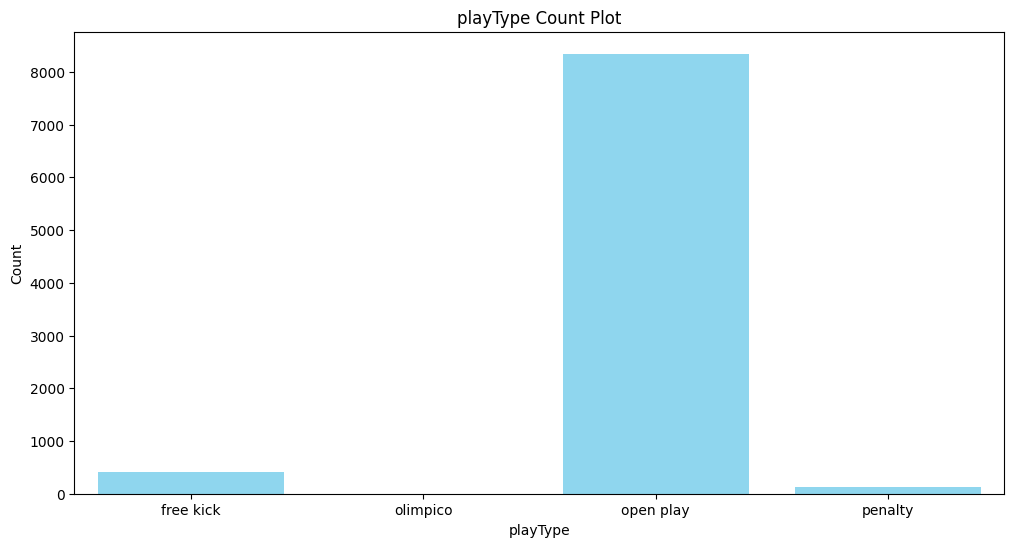

In [28]:
count_plot(df, 'playType', sorted=False)

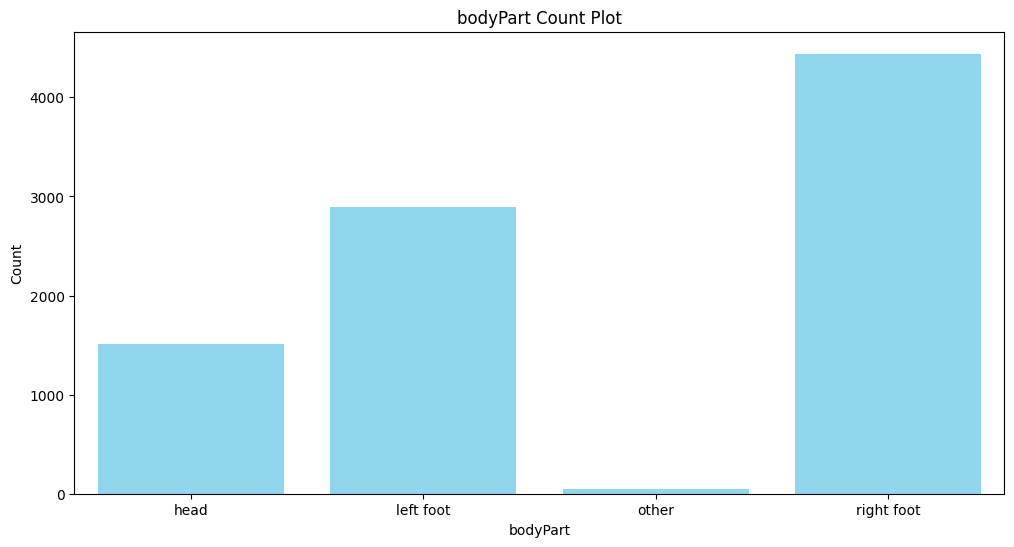

In [29]:
count_plot(df, 'bodyPart', sorted=False)

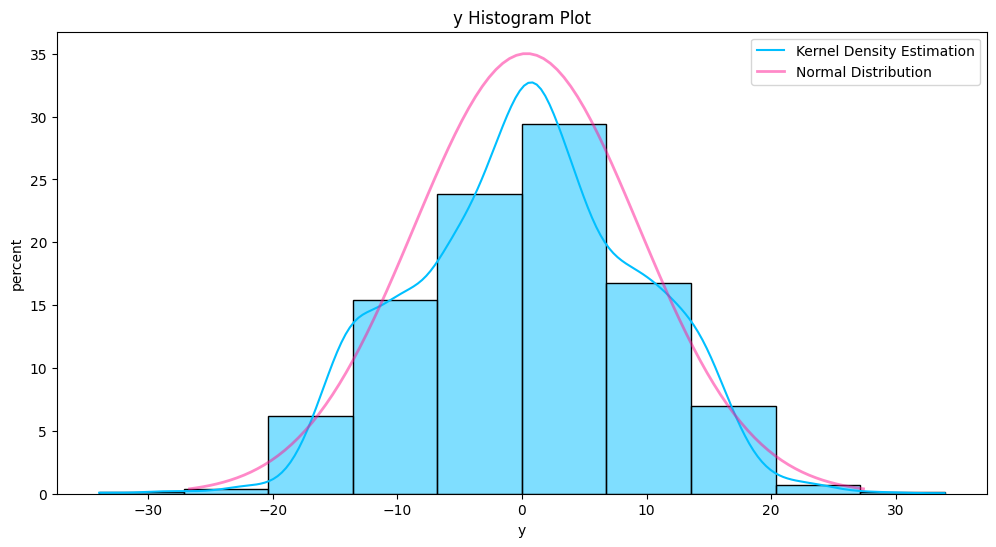

In [30]:
hist_plot(df, 'y', kde=True, normal_estimation=True, stat='percent')

As we can see the distribution of the `y` column is almost symmetric. This means that the shots are taken from both sides of the field.

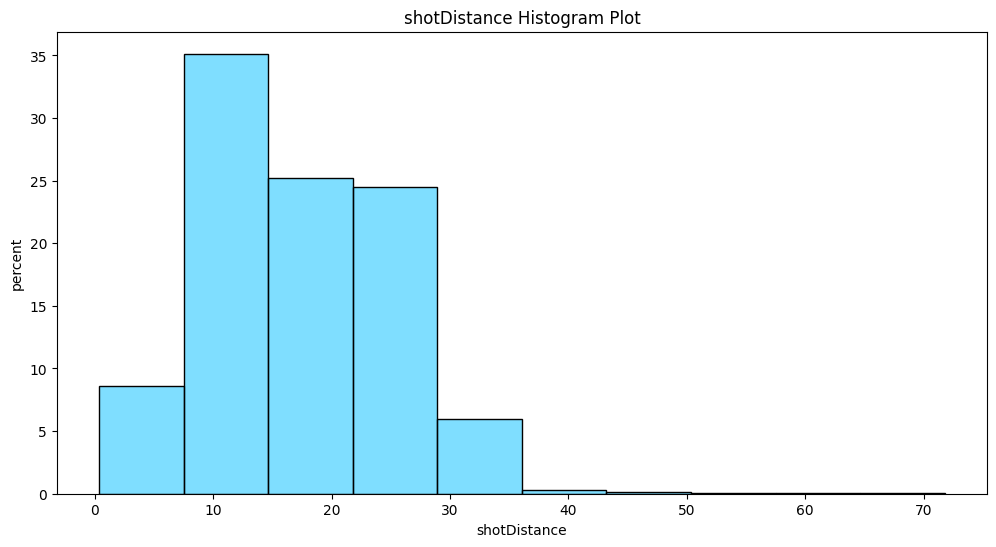

In [31]:
hist_plot(df, 'shotDistance', kde=False, normal_estimation=False, stat='percent')

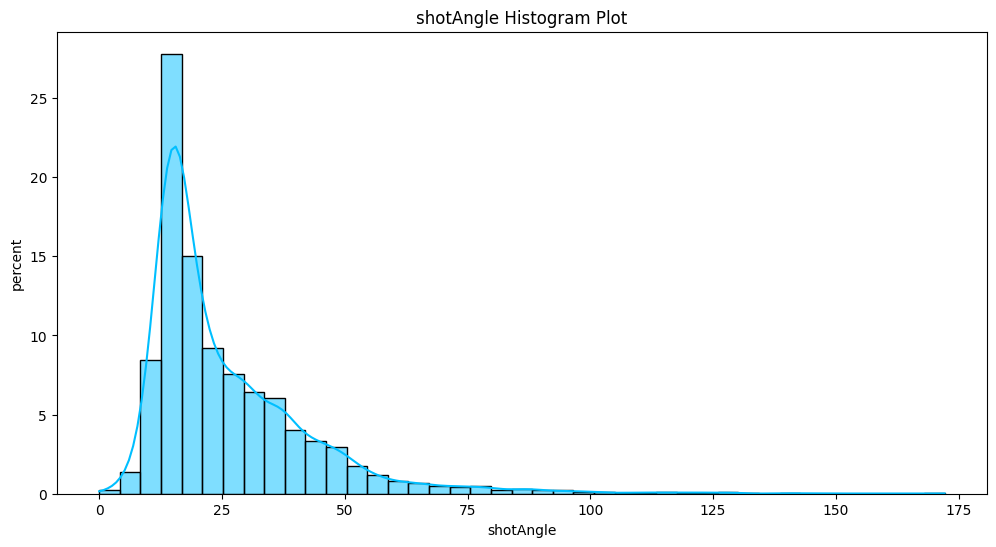

In [32]:
hist_plot(df, 'shotAngle', kde=True, normal_estimation=False, stat='percent', rule='rice')

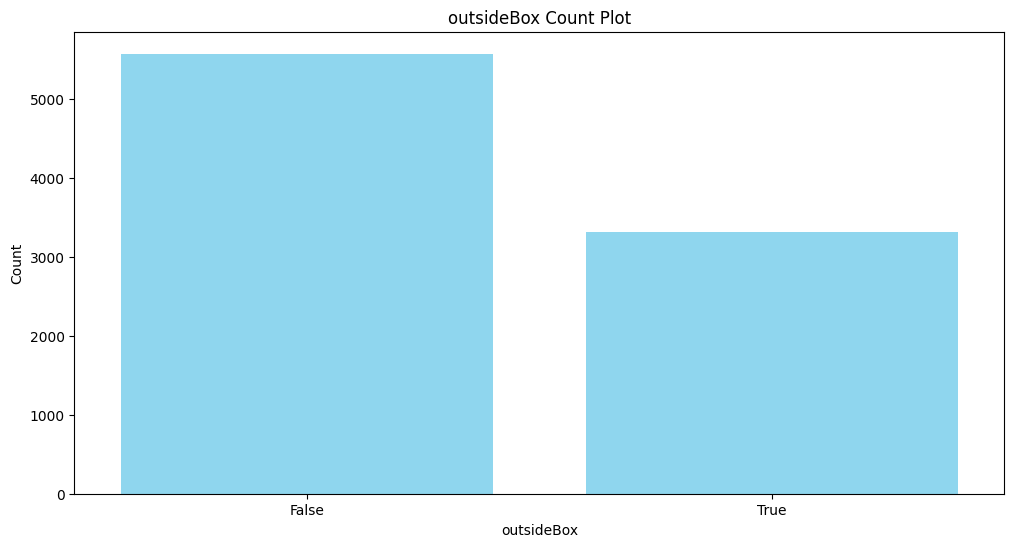

In [33]:
count_plot(df, 'outsideBox', sorted=False)

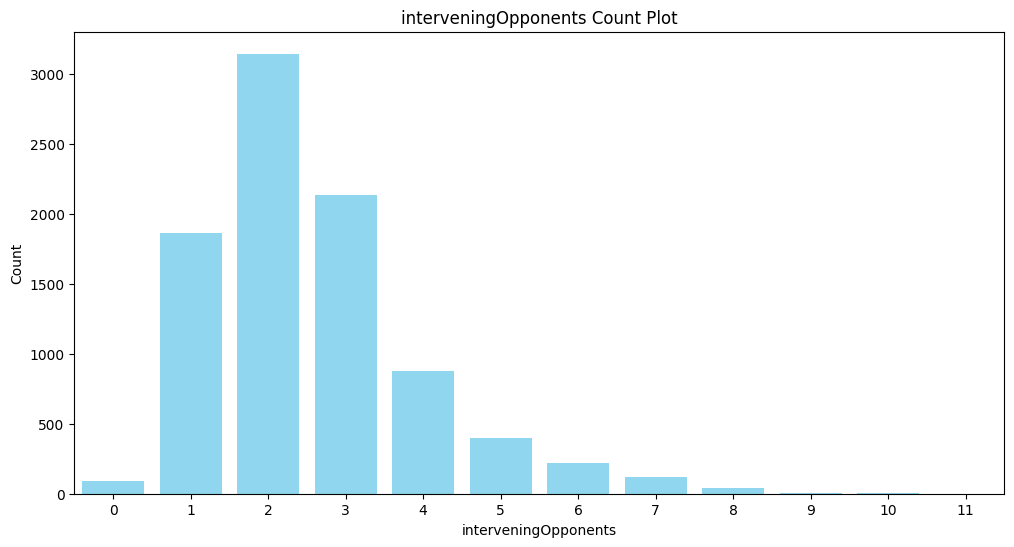

In [34]:
count_plot(df, 'interveningOpponents', sorted=False)

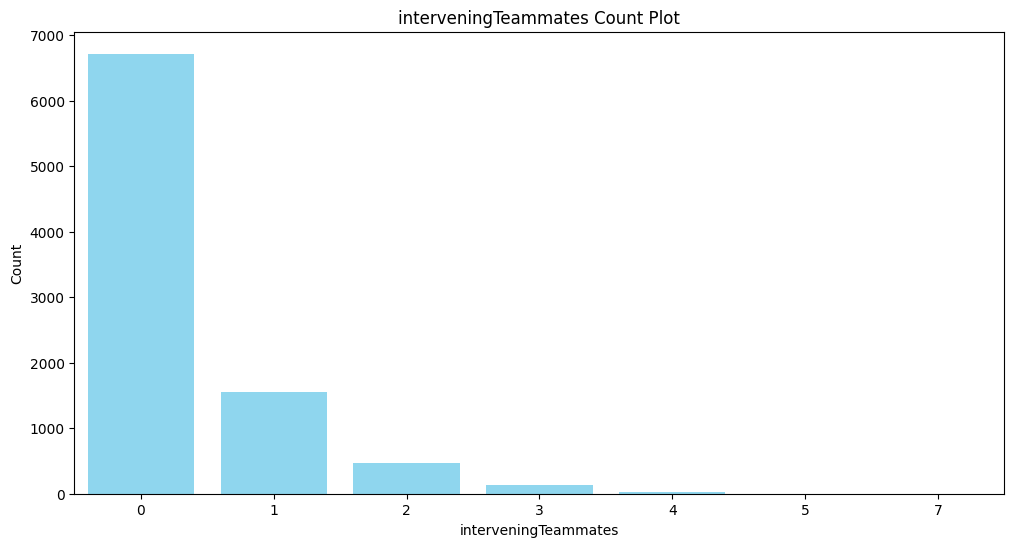

In [35]:
count_plot(df, 'interveningTeammates', sorted=False)

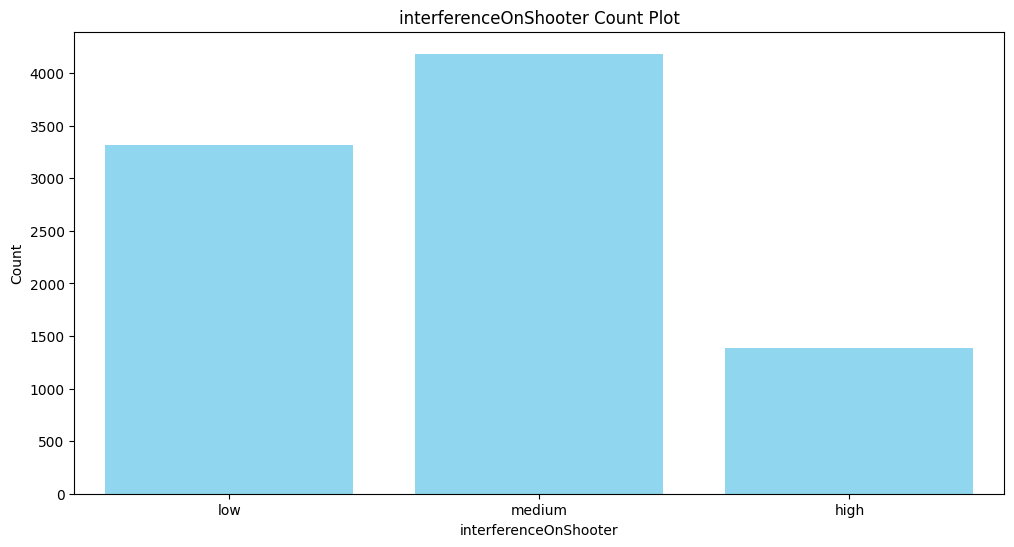

In [36]:
count_plot(df, 'interferenceOnShooter', sorted=False)

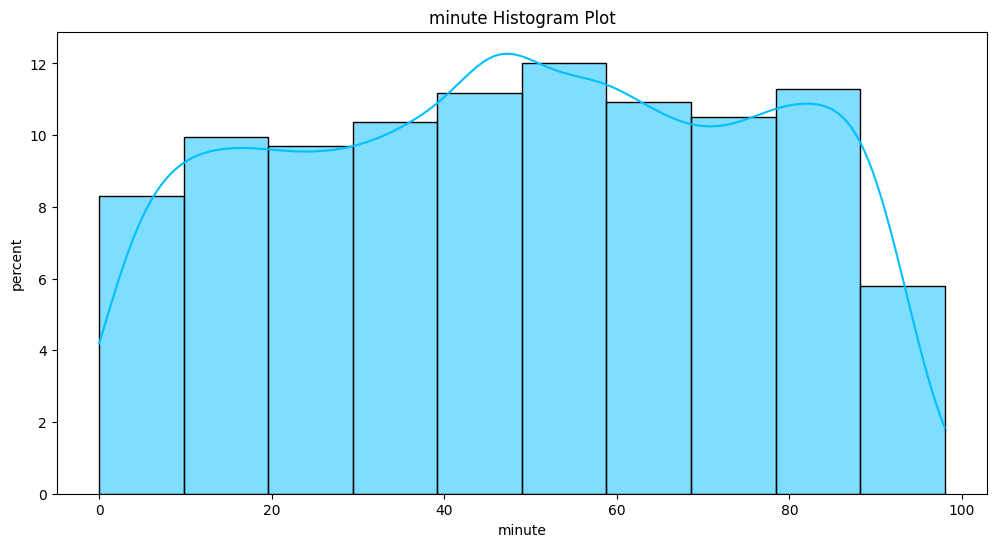

In [37]:
hist_plot(df, 'minute', kde=True, normal_estimation=False, stat='percent', bins=10)

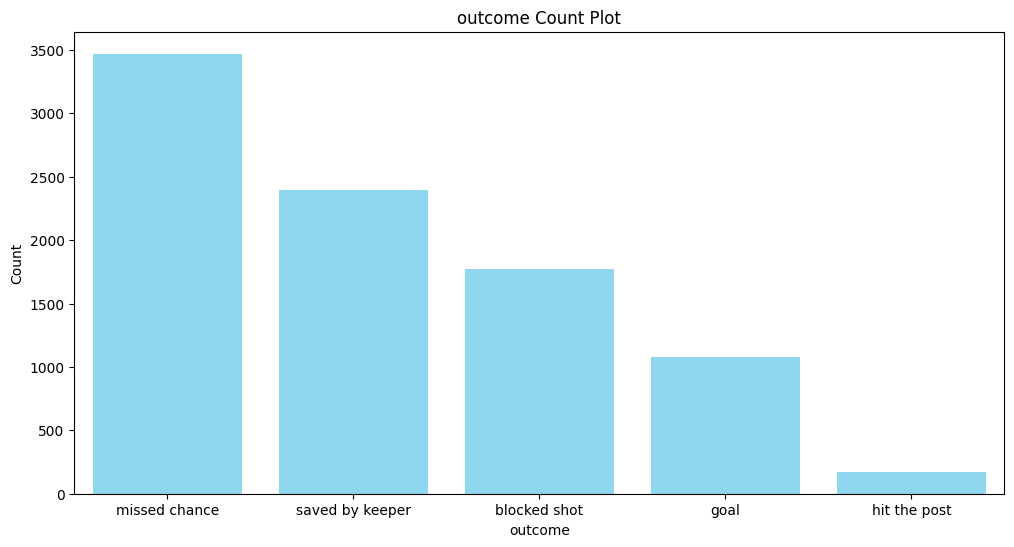

In [38]:
count_plot(df, 'outcome', sorted=True)

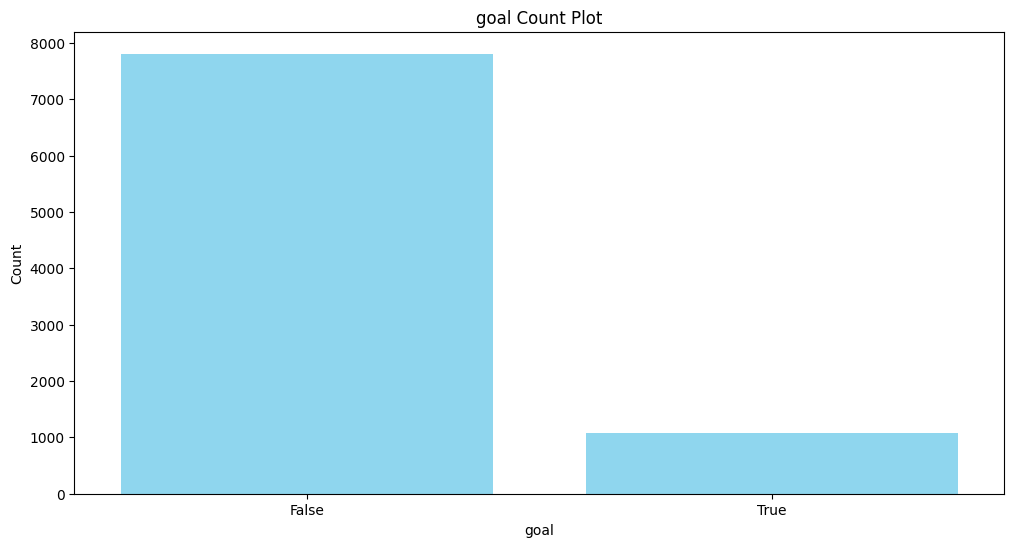

In [39]:
count_plot(df, 'goal', sorted=False)

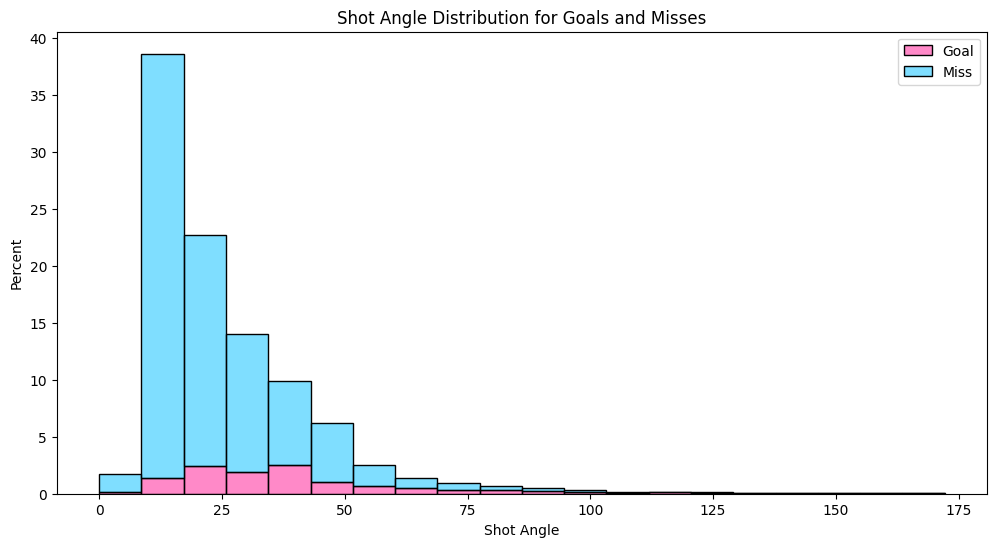

In [40]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='shotAngle', hue='goal', bins=20, palette=['deepskyblue', 'deeppink'], alpha=0.5, multiple='stack', edgecolor='black', stat='percent')
plt.xlabel('Shot Angle')
plt.ylabel('Percent')
plt.title('Shot Angle Distribution for Goals and Misses')
plt.legend(['Goal', 'Miss'])
plt.show()

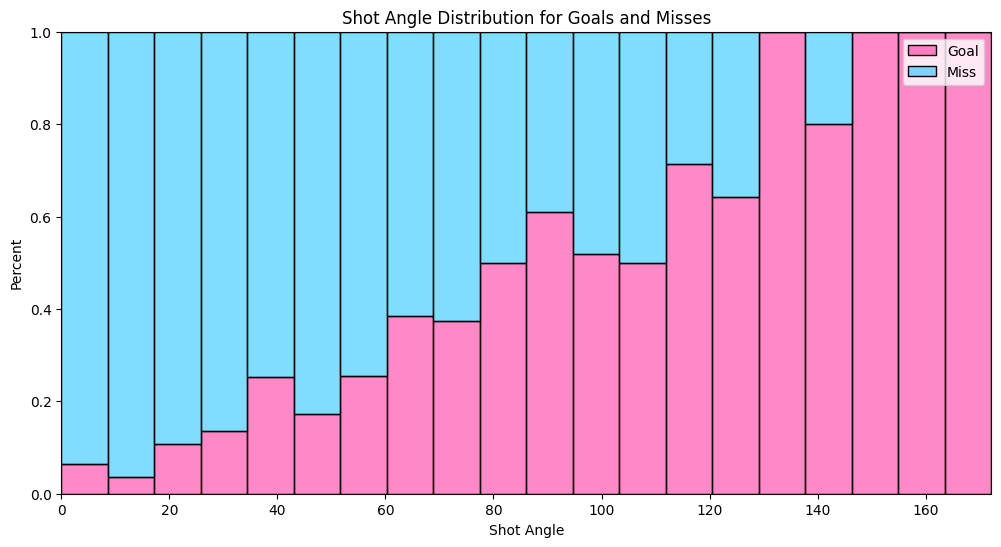

In [41]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='shotAngle', hue='goal', bins=20, palette=['deepskyblue', 'deeppink'], alpha=0.5, multiple='fill', edgecolor='black', stat='percent')
plt.xlabel('Shot Angle')
plt.ylabel('Percent')
plt.title('Shot Angle Distribution for Goals and Misses')
plt.legend(['Goal', 'Miss'])
plt.show()

We can clearly see that by increasing the angle, the likelihood of scoring a goal increases.

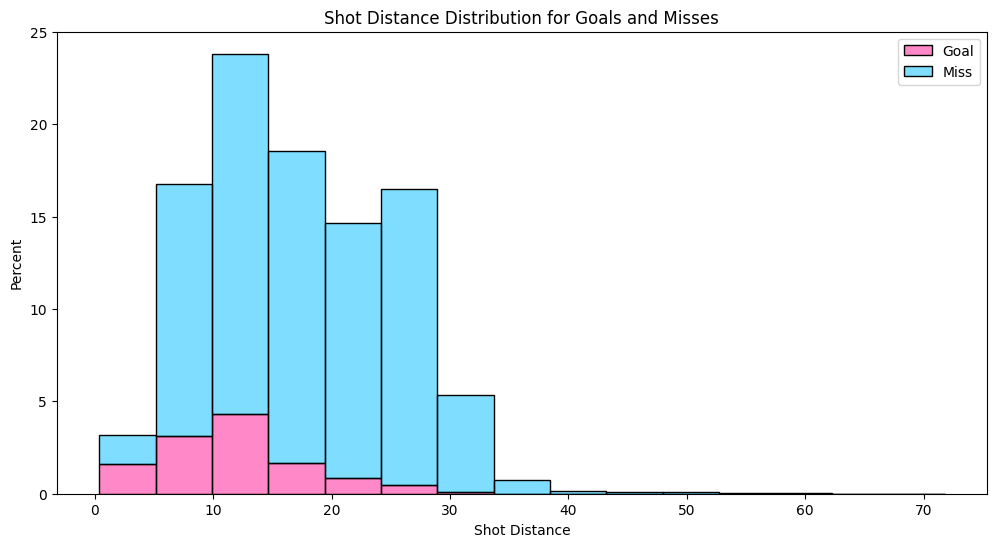

In [42]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='shotDistance', hue='goal', bins=15, palette=['deepskyblue', 'deeppink'], alpha=0.5, multiple='stack', edgecolor='black', stat='percent')
plt.xlabel('Shot Distance')
plt.ylabel('Percent')
plt.title('Shot Distance Distribution for Goals and Misses')
plt.legend(['Goal', 'Miss'])
plt.show()

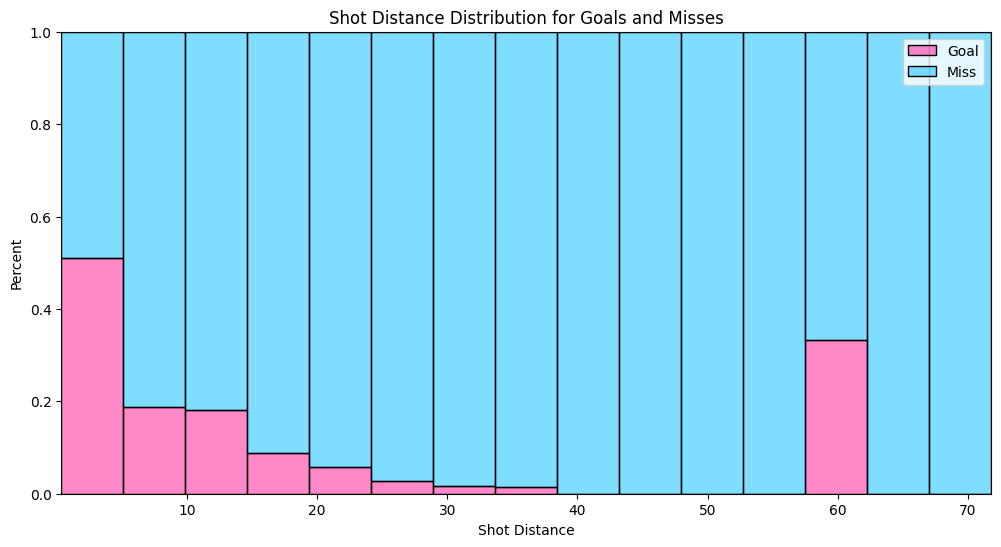

In [43]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='shotDistance', hue='goal', bins=15, palette=['deepskyblue', 'deeppink'], alpha=0.5, multiple='fill', edgecolor='black', stat='percent')
plt.xlabel('Shot Distance')
plt.ylabel('Percent')
plt.title('Shot Distance Distribution for Goals and Misses')
plt.legend(['Goal', 'Miss'])
plt.show()

In [44]:
average_distance = df.groupby('goal')['shotDistance'].mean()
average_distance

goal
False    17.938538
True     11.730595
Name: shotDistance, dtype: float64

We can see that by increasing the distance, the likelihood of scoring a goal decereases. The peak at around 60 meters is due to low number of shots taken from that distance.  
The average distance of shots leading to goals is lower than the average distance of other shots.

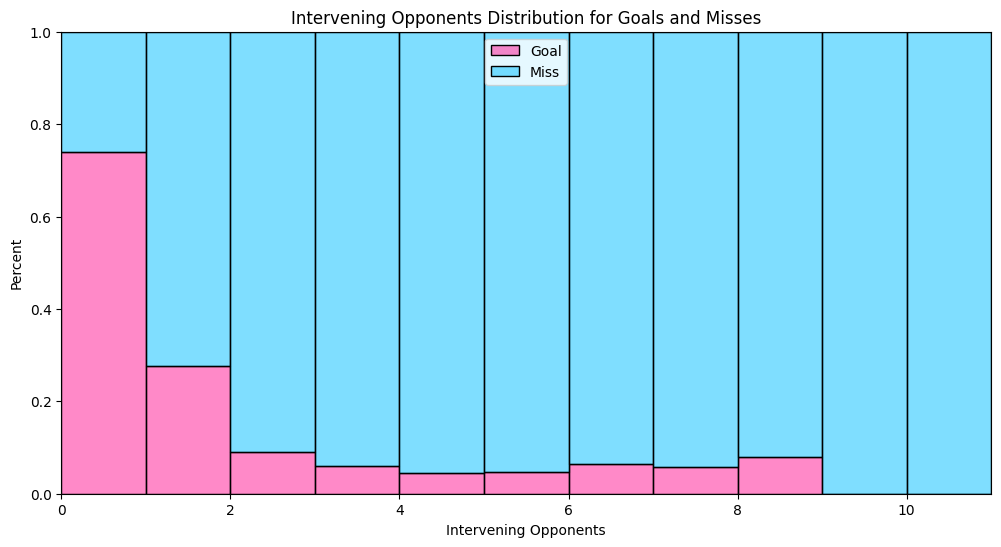

In [45]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='interveningOpponents', hue='goal', bins=11, palette=['deepskyblue', 'deeppink'], alpha=0.5, multiple='fill', edgecolor='black', stat='percent')
plt.xlabel('Intervening Opponents')
plt.ylabel('Percent')
plt.title('Intervening Opponents Distribution for Goals and Misses')
plt.legend(['Goal', 'Miss'])
plt.show()

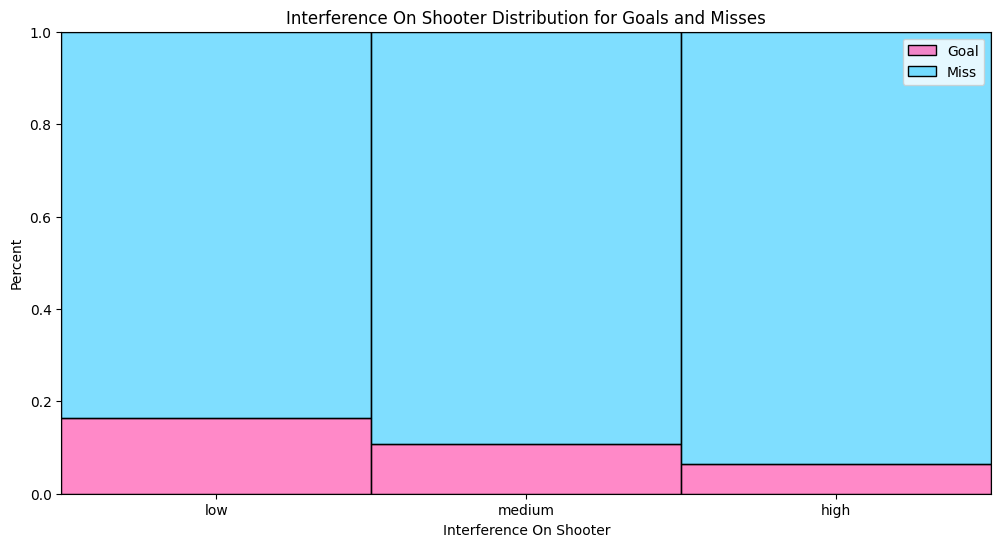

In [46]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='interferenceOnShooter', hue='goal', bins=3, palette=['deepskyblue', 'deeppink'], alpha=0.5, multiple='fill', edgecolor='black', stat='percent')
plt.xlabel('Interference On Shooter')
plt.ylabel('Percent')
plt.title('Interference On Shooter Distribution for Goals and Misses')
plt.legend(['Goal', 'Miss'])
plt.show()

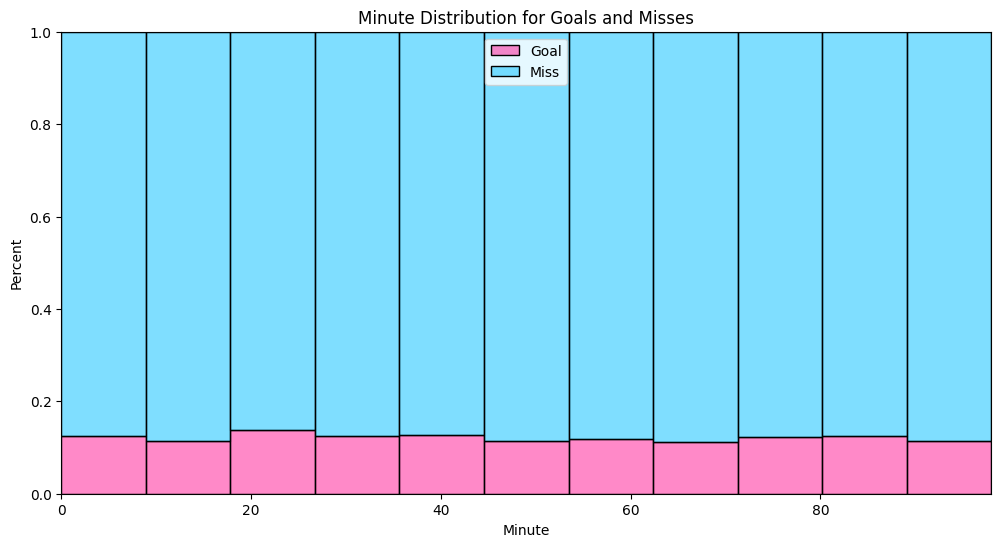

In [47]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='minute', hue='goal', bins=11, palette=['deepskyblue', 'deeppink'], alpha=0.5, multiple='fill', edgecolor='black', stat='percent')
plt.xlabel('Minute')
plt.ylabel('Percent')
plt.title('Minute Distribution for Goals and Misses')
plt.legend(['Goal', 'Miss'])
plt.show()

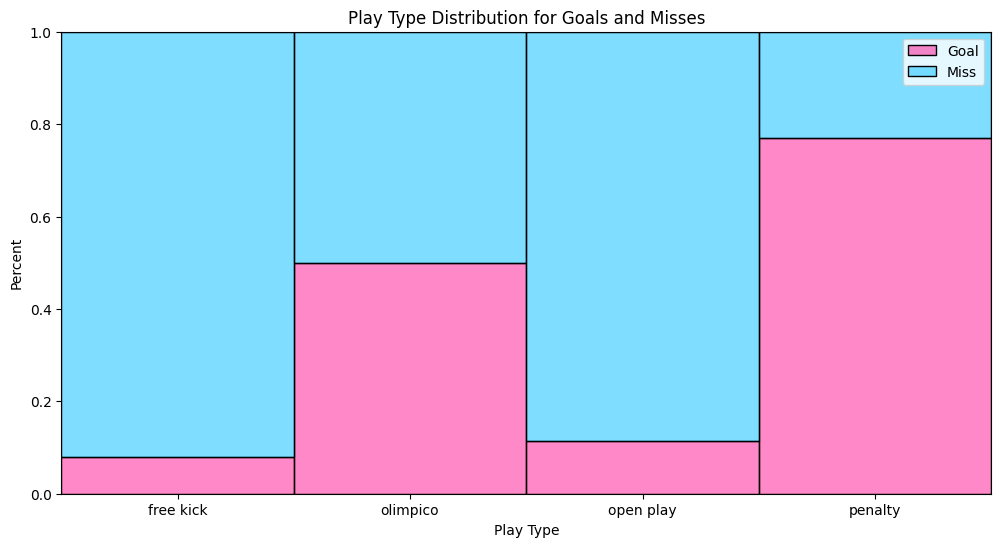

In [48]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='playType', hue='goal', bins=4, palette=['deepskyblue', 'deeppink'], alpha=0.5, multiple='fill', edgecolor='black', stat='percent')
plt.xlabel('Play Type')
plt.ylabel('Percent')
plt.title('Play Type Distribution for Goals and Misses')
plt.legend(['Goal', 'Miss'])
plt.show()

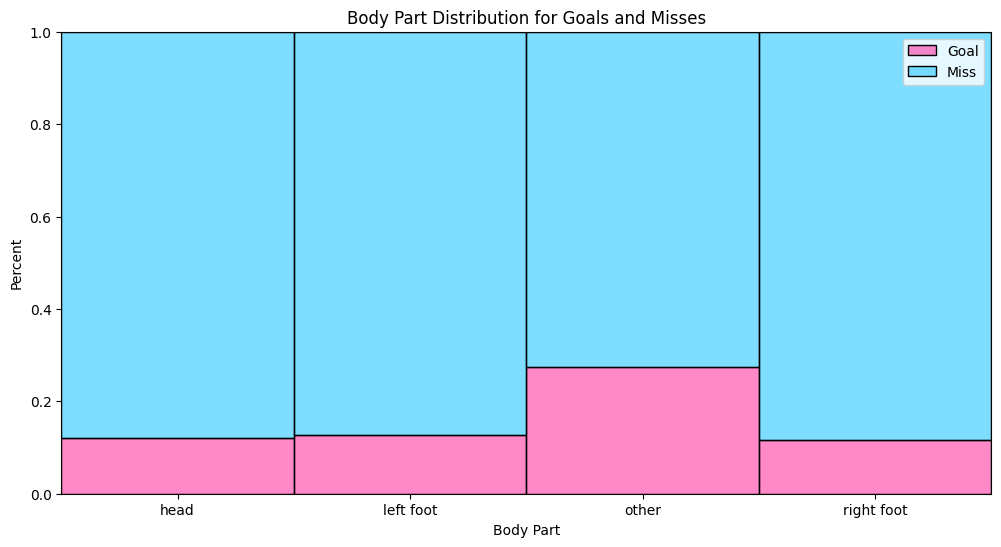

In [49]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='bodyPart', hue='goal', bins=4, palette=['deepskyblue', 'deeppink'], alpha=0.5, multiple='fill', edgecolor='black', stat='percent')
plt.xlabel('Body Part')
plt.ylabel('Percent')
plt.title('Body Part Distribution for Goals and Misses')
plt.legend(['Goal', 'Miss'])
plt.show()

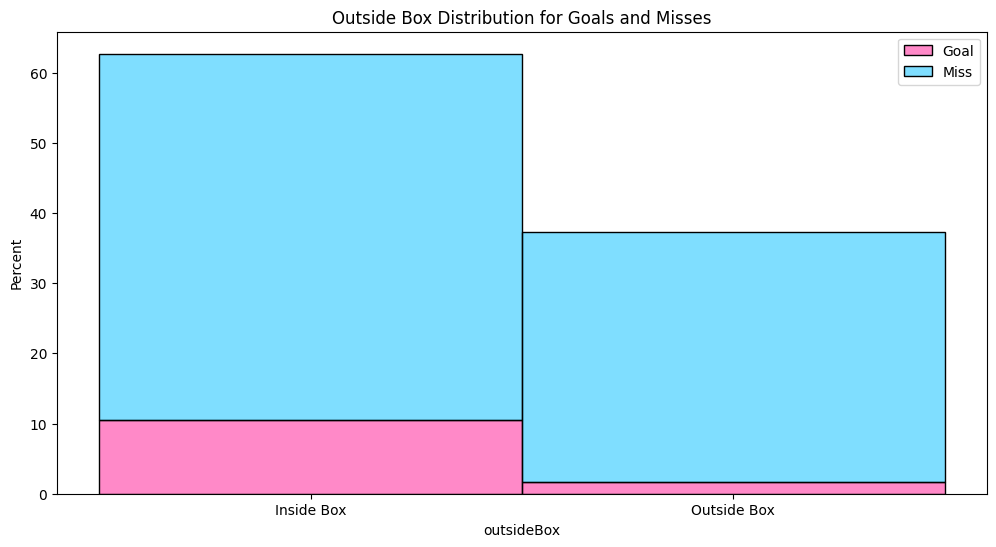

In [50]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='outsideBox', hue='goal', bins=2, palette=['deepskyblue', 'deeppink'], alpha=0.5, multiple='stack', edgecolor='black', stat='percent', discrete=True)
plt.ylabel('Percent')
plt.title('Outside Box Distribution for Goals and Misses')
plt.legend(['Goal', 'Miss'])
plt.xticks([0, 1], ['Inside Box', 'Outside Box'])
plt.show()

## <a id='toc6_'></a>[Feature Importance](#toc0_)

### <a id='toc6_1_'></a>[Mutual Information](#toc0_)

In [51]:
df.columns

Index(['matchId', 'playerId', 'playType', 'bodyPart', 'x', 'y', 'shotDistance',
       'shotAngle', 'outsideBox', 'interveningOpponents',
       'interveningTeammates', 'interferenceOnShooter', 'secondsPassed',
       'minute', 'second', 'outcome', 'goal'],
      dtype='object')

In [52]:
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder()
df_encoded = df.copy()
df_encoded['matchId'] = label_encoder.fit_transform(df_encoded['matchId'])
df_encoded['playerId'] = label_encoder.fit_transform(df_encoded['playerId'])
df_encoded['playType'] = label_encoder.fit_transform(df_encoded['playType'])
df_encoded['bodyPart'] = label_encoder.fit_transform(df_encoded['bodyPart'])
df_encoded['interferenceOnShooter'] = ordinal_encoder.fit_transform(df_encoded['interferenceOnShooter'].values.reshape(-1, 1))
df_encoded['outcome'] = label_encoder.fit_transform(df_encoded['outcome'])
df_encoded.head()

,matchId,playerId,playType,bodyPart,x,y,shotDistance,shotAngle,outsideBox,interveningOpponents,interveningTeammates,interferenceOnShooter,secondsPassed,minute,second,outcome,goal
0,231,5,2,3,13.47,-11.22,17.530810,18.5441,False,1,0,2.0,4209,70,9,1,True
1,78,67,2,1,9.48,14.22,17.090313,13.9826,False,3,0,2.0,3304,55,4,4,False
2,14,147,0,1,29.43,-1.25,29.456534,14.1533,True,6,2,1.0,5191,86,31,4,False
3,48,146,2,3,26.93,1.00,26.948560,15.4584,True,4,1,2.0,4622,77,2,3,False
4,20,149,2,3,10.72,5.24,11.932141,31.3159,False,2,0,2.0,4606,76,46,1,True


In [53]:
def calculate_mutual_information(df, target_column):
	mutual_info = {}
	for col in df.columns:
		if col == target_column:
			continue
		mutual_info[col] = mutual_info_classif(df[[col]], df[target_column])[0]
	return mutual_info


In [54]:
mutual_info = calculate_mutual_information(df_encoded, 'goal')
mutual_info_df = pd.DataFrame(mutual_info.items(), columns=['Feature', 'Mutual Information'])
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)
mutual_info_df.reset_index(drop=True, inplace=True)
mutual_info_df

,Feature,Mutual Information
0,outcome,0.154496
1,shotDistance,0.056758
2,shotAngle,0.056197
3,interveningOpponents,0.040938
4,x,0.033499
5,y,0.031554
6,playType,0.018434
7,outsideBox,0.014337
8,interveningTeammates,0.005836
9,interferenceOnShooter,0.002847


### <a id='toc6_2_'></a>[Correlation](#toc0_)

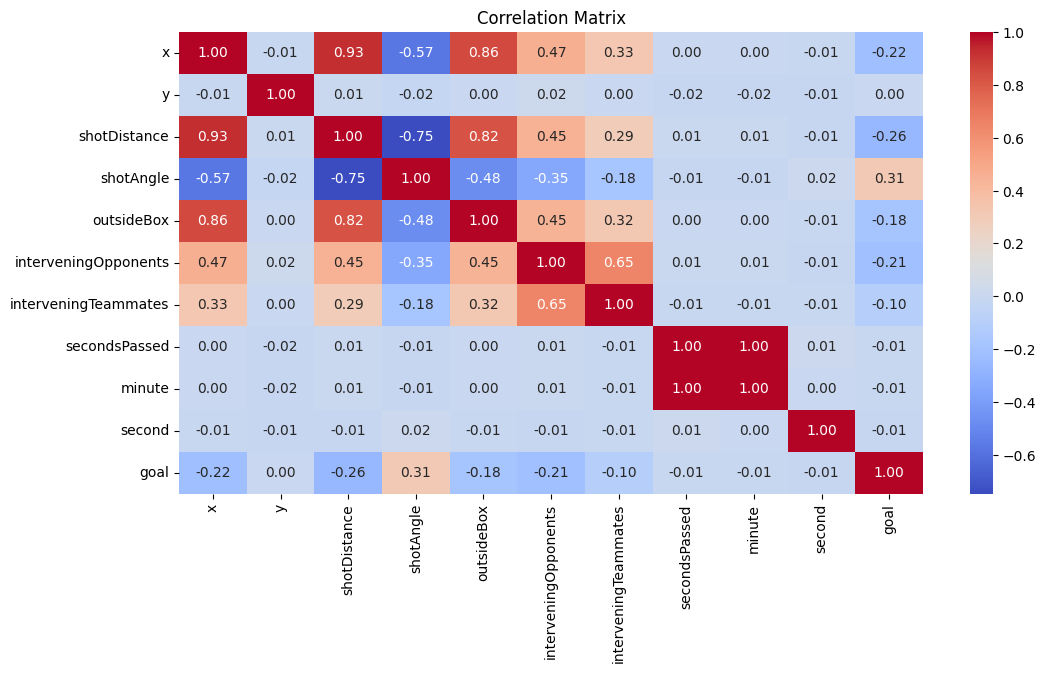

In [55]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [56]:
correlation_df = df.corr()['goal']
correlation_df = correlation_df.drop('goal')
correlation_df = correlation_df.reindex(correlation_df.abs().sort_values(ascending=False).index)
correlation_df

shotAngle               0.313165
shotDistance           -0.260733
x                      -0.216209
interveningOpponents   -0.213680
outsideBox             -0.181599
interveningTeammates   -0.101162
second                 -0.012555
secondsPassed          -0.006863
minute                 -0.006726
y                       0.001947
Name: goal, dtype: float64

## <a id='toc7_'></a>[Evaluation](#toc0_)

### <a id='toc7_1_'></a>[Train-Test Split](#toc0_)

In [57]:
X = df_encoded.drop(columns=['outcome', 'goal'])
y = df_encoded['goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=RANDOM_STATE)
print(f"Count of instances in\n Whole Dataset: {X.shape[0]}\n Training set: {X_train.shape[0]}\n Testing set: {X_test.shape[0]}")


Count of instances in
 Whole Dataset: 8891
 Training set: 7112
 Testing set: 1779


### <a id='toc7_2_'></a>[Training a Model](#toc0_)

We will use a simple random forest classifier to predict the outcome of the shots.

In [58]:
def train_and_predict(X_train, y_train, X_test, y_test):
	rf = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, max_depth=MAX_DEPTH)
	rf.fit(X_train, y_train)
	y_pred = rf.predict(X_test)
	_classification_report = classification_report(y_test, y_pred)
	_confusion_matrix = confusion_matrix(y_test, y_pred)
	return _classification_report, _confusion_matrix


In [59]:
def plot_confusion_matrix(_confusion_matrix):
	plt.figure(figsize=(12, 6))
	sns.heatmap(_confusion_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
	plt.xlabel('Predicted Label')
	plt.ylabel('True Label')
	plt.title('Confusion Matrix')
	plt.show()


### <a id='toc7_3_'></a>[Evaluation](#toc0_)

#### <a id='toc7_3_1_'></a>[Raw data](#toc0_)

              precision    recall  f1-score   support

       False       0.89      0.99      0.94      1554
        True       0.74      0.13      0.22       225

    accuracy                           0.88      1779
   macro avg       0.82      0.56      0.58      1779
weighted avg       0.87      0.88      0.85      1779



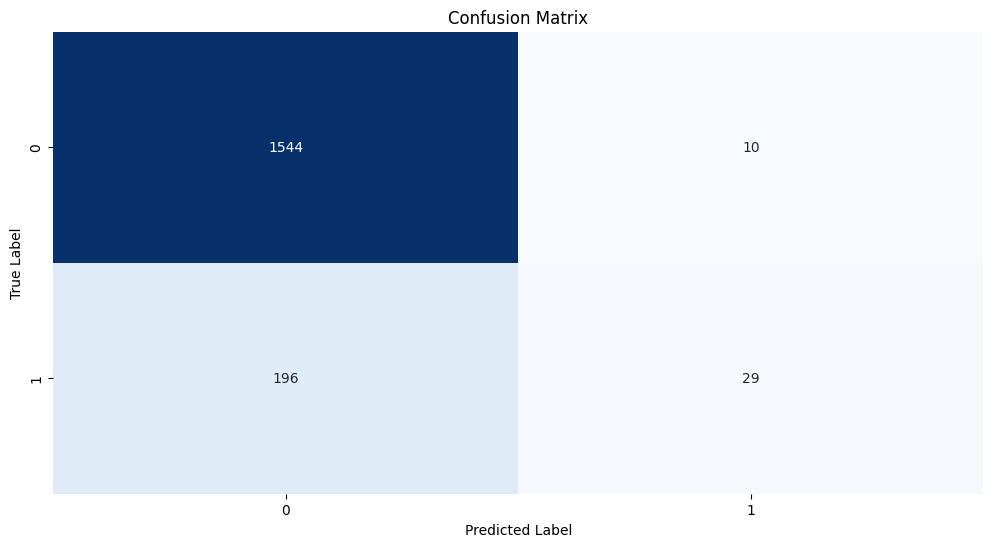

In [60]:
raw_X_train = X_train.drop(columns=['shotDistance', 'shotAngle', 'outsideBox', 'secondsPassed'])
raw_X_test = X_test.drop(columns=['shotDistance', 'shotAngle', 'outsideBox', 'secondsPassed'])
_classification_report, _confusion_matrix = train_and_predict(raw_X_train, y_train, raw_X_test, y_test)
print(_classification_report)
plot_confusion_matrix(_confusion_matrix)

### <a id='toc7_4_'></a>[Modified data](#toc0_)

              precision    recall  f1-score   support

       False       0.90      0.99      0.94      1554
        True       0.70      0.21      0.33       225

    accuracy                           0.89      1779
   macro avg       0.80      0.60      0.63      1779
weighted avg       0.87      0.89      0.86      1779



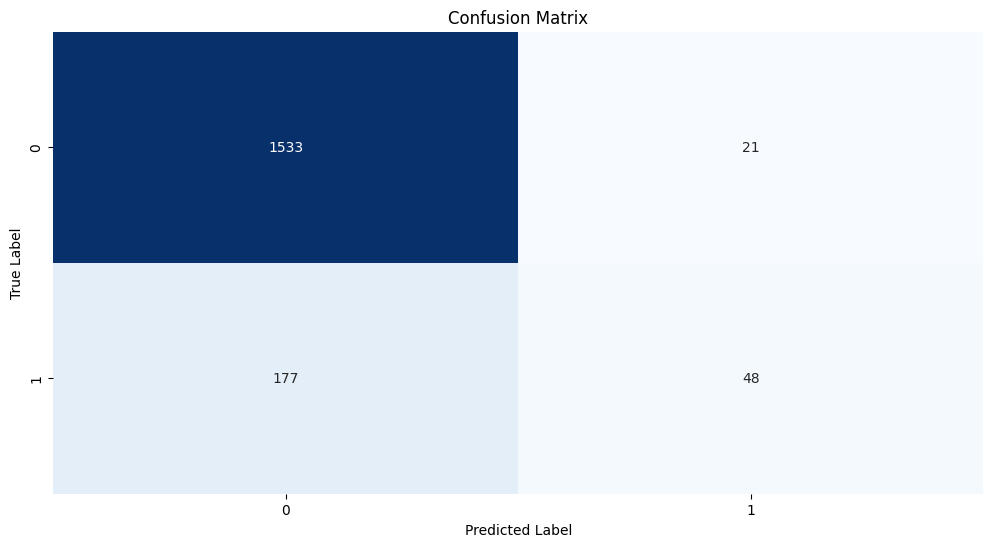

In [61]:
modified_X_train = X_train.drop(columns=['matchId', 'playerId', 'second', 'secondsPassed', 'minute'])
modified_X_test = X_test.drop(columns=['matchId', 'playerId', 'second', 'secondsPassed', 'minute'])
_classification_report, _confusion_matrix = train_and_predict(modified_X_train, y_train, modified_X_test, y_test)
print(_classification_report)
plot_confusion_matrix(_confusion_matrix)

## <a id='toc8_'></a>[Heat Map](#toc0_)

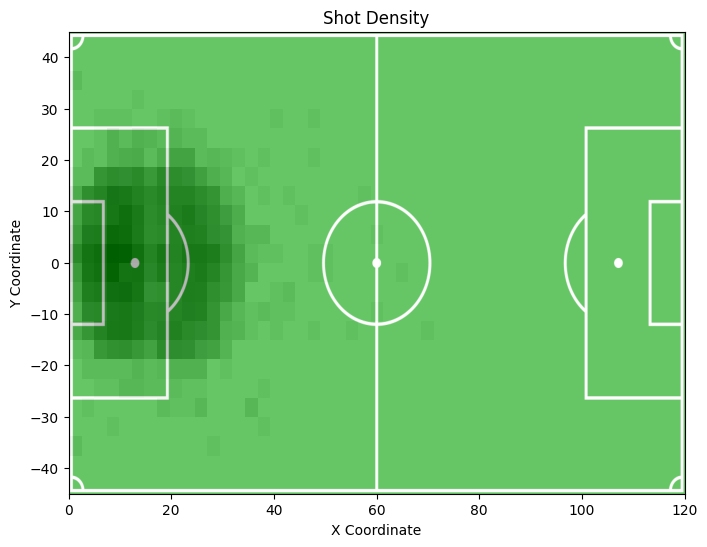

In [90]:
bins = [np.linspace(0, MAX_FIELD_LENGTH, 50), np.linspace(-MAX_FIELD_WIDTH / 2, MAX_FIELD_WIDTH / 2, 25)]
shot_density, xedges, yedges = np.histogram2d(df['x'], df['y'], bins=bins)
shot_density = shot_density.T
plt.figure(figsize=(12, 6))
# take logarithm of shot density to make it more interpretable
shot_density = np.log1p(shot_density)
# put field.png as backgroung of the plot with transparency
plt.imshow(shot_density, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Greys')
plt.imshow(plt.imread('field.png'), extent=[0, MAX_FIELD_LENGTH, -MAX_FIELD_WIDTH / 2, MAX_FIELD_WIDTH / 2], alpha=0.6)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Shot Density')
plt.show()


## <a id='toc9_'></a>[Questions](#toc0_)

### <a id='toc9_1_'></a>[Question 1](#toc0_)

**Describe your strategy for addressing challenges such as handling missing
values and categorical features. Could you also elaborate on your feature
selection metrics and explain the rationale behind them?**

There were only 34 rows with missing values in the dataset. The missing values were in the `interferenceOnShooter` and `outcome` columns. Since the `outcome` column is our target variable, we first dropped the rows with missing values in this column. After that, we no longer had any missing values in the dataset.  

Then we converted the `interferenceOnShooter` column to an ordered categorical type. This will help us later when we perform the analysis.  
Also, we converted the `playType`, `bodyPart` and `outcome` columns to categorical types.  
We left the `matchId` and `playerId` columns as object types because they are identifiers and we will not use them in the analysis.

We have used mutual information and correlation to find the most important features. 

Mutual information is a measure of the amount of information that one random variable contains about another random variable. It is used to find the relationship between two variables. The higher the mutual information, the more information the two variables share. The mutual information of two jointly discrete random variables $X$ and $Y$ is calculated as a double sum:
$$ I(X;Y) = \sum_{x \in X} \sum_{y \in Y} p(x,y) \log \left( \frac{p(x,y)}{p(x)p(y)} \right) $$

Correlation is a measure of the strength and direction of a linear relationship between two variables. It is used to find the relationship between two variables. The correlation of two variables $X$ and $Y$ is calculated as:
$$ \rho(X,Y) = \frac{cov(X,Y)}{\sigma_X \sigma_Y} $$

### <a id='toc9_2_'></a>[Question 2](#toc0_)

**Why didn’t we use regression to predict whether a shot would result in a goal?**

One reason why regression may not be the primary choice for predicting whether a shot will result in a goal is due to the nature of the target variable, which is binary (goal or no goal). Regression models typically assume a continuous target variable, and while they can be adapted to handle binary outcomes (e.g., logistic regression), there are alternative models that are specifically designed for binary classification problems.

In the context of predicting goals in football, the focus is often on making accurate predictions rather than interpreting the impact of individual features on the outcome. Machine learning algorithms, such as decision trees, random forests, gradient boosting, or neural networks, are well-suited for this task as they can capture complex patterns and nonlinear relationships in the data. These algorithms are powerful tools for making predictions and have been widely adopted in sports analytics.

Additionally, the dataset may contain imbalanced classes, where the number of shots resulting in goals is significantly lower than the number of shots that do not result in goals. This imbalance can affect the performance of regression models, as they typically assume equal importance of positive and negative examples. Machine learning algorithms offer techniques, such as class weighting or resampling, to handle imbalanced datasets more effectively.

Furthermore, regression models often assume linear relationships between the features and the target variable. However, the relationship between shot characteristics and the outcome of a goal may not always be linear. Machine learning algorithms, particularly tree-based models, can capture nonlinear relationships and complex interactions between features more effectively.

By using machine learning algorithms, analysts can leverage the flexibility and adaptability of these models to make accurate predictions. These algorithms can handle high-dimensional data, capture complex patterns, and be fine-tuned through hyperparameter optimization. Additionally, ensemble methods, such as random forests or gradient boosting, can reduce overfitting and improve generalization performance.

In summary, while regression models have their place in statistical analysis, the task of predicting goals in football may benefit more from the advanced techniques offered by machine learning algorithms. These algorithms provide a comprehensive toolkit for handling binary classification problems, imbalanced datasets, and complex relationships between features and outcomes.

### <a id='toc9_3_'></a>[Question 3](#toc0_)

**How would you go about verifying the accuracy of the given formula used to
calculate the shot angle in the preprocessing section?**

One way to verify the accuracy of the formula is to test it with known angles. Set up scenarios where you know the expected shot angle based on the positions of the shooter and the goal. Calculate the shot angle using the given formula and compare it with the expected value. Ensure that the calculated angle matches the known angle within an acceptable tolerance. 

Another way could be plotting the shooter's position and the goal on a coordinate plane. Draw the line connecting the shooter's position to the goal, and calculate the angle using geometric principles. Compare this manually calculated angle with the angle obtained from the formula. Visual verification can provide a good sanity check.

Additionally, we can research similar formulas or methods used in sports analytics or physics to calculate angles. Compare the results obtained from the given formula with those obtained from alternative methods. Consistency with other formulas can provide additional validation.